# Homework 7

Kanchana Raja, UNI: kr2702

I did not have any collaborators.

# Problem 1

In [66]:
import math
import numpy as np
import kplr

# Find the target KOI.
client = kplr.API()
koi = client.koi(97.01)

# Get a list of light curve datasets.
lcs = koi.get_light_curves(short_cadence=False)

# Open the first dataset and read it
f = lcs[0].open()
hdu_data = f[1].data
time = hdu_data["time"]  # get the time of each observation
flux = hdu_data["sap_flux"] # get the flux
flux_err = hdu_data["sap_flux_err"] # get the error in the flux
f.close()

time_ext=[]
flux_ext=[]
flux_err_ext=[]

#extract the data in the time range 124 < t < 125
for i in range(0, len(time)):
    if time[i]>124 and time[i]<125:
        time_ext.append(time[i])
        flux_ext.append(flux[i])
        flux_err_ext.append(flux_err[i])

print(len(time_ext))
print(flux_ext)


49
[104186.81, 104175.73, 104183.13, 104161.03, 104177.14, 104169.26, 104180.85, 104151.02, 104183.96, 104171.34, 104176.87, 104187.3, 104189.58, 104187.68, 104181.26, 104175.77, 104179.58, 104179.93, 104179.43, 104082.04, 103619.63, 103486.21, 103454.16, 103412.99, 103405.58, 103392.38, 103434.2, 103486.57, 103571.31, 103979.73, 104176.46, 104172.52, 104163.95, 104172.02, 104171.56, 104194.48, 104180.95, 104157.11, 104182.98, 104176.45, 104179.43, 104176.69, 104181.37, 104176.25, 104182.89, 104185.48, 104192.16, 104184.27, 104174.18]


In [82]:
def normalize_flux(flux, time, flux_err):
    flux = np.array(flux)
    f_bar = np.mean(flux)
    sigma = np.std(flux)
    #print(len(flux))
    #print(f_bar)
    #print(sigma)

    new_flux = []
    new_time = []
    new_flux_err = []

    for i in range(0, len(flux)):
        if(abs(flux[i]-f_bar)/sigma) > 2:
            pass
        else:
            new_flux.append(flux[i])
            new_time.append(time[i])
            new_flux_err.append(flux_err[i]) 
    
    return(new_flux, new_time, new_flux_err)

        

(flux_ext2, time_ext2, flux_err_ext2) = normalize_flux(flux_ext, time_ext, flux_err_ext)
print(len(flux_ext2))
(flux_ext3, time_ext3, flux_err_ext3) = normalize_flux(flux_ext2, time_ext2, flux_err_ext2)
print(len(flux_ext3))
(flux_ext4, time_ext4, flux_err_ext4) = normalize_flux(flux_ext3, time_ext3, flux_err_ext3)
print(len(flux_ext4))
(flux_ext5, time_ext5, flux_err_ext5) = normalize_flux(flux_ext4, time_ext4, flux_err_ext4)
print(len(flux_ext5))
(flux_ext6, time_ext6, flux_err_ext6) = normalize_flux(flux_ext5, time_ext5, flux_err_ext5)
print(len(flux_ext6))
(flux_ext7, time_ext7, flux_err_ext7) = normalize_flux(flux_ext6, time_ext6, flux_err_ext6)
print(len(flux_ext7))

mean_flux = np.mean(flux_ext7)
sigma_flux = np.std(flux_ext7)
print(mean_flux)
print(sigma_flux)

42
40
38
36
33
32
104179.0
5.16389


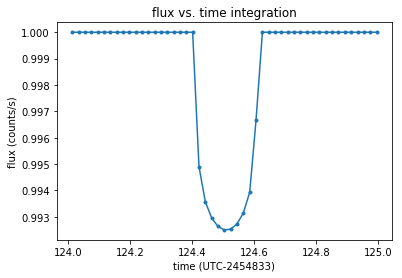

Chi-squared:  0.4924532005461551


In [149]:
import numpy as np
import math

#guess values for p, t0, and tau (trial and error)
p = 0.0775
tau = 0.1
t_0 = 124.51
n = 1000


#update the limb-darkening function I(r)
def I_func(r):
    u = math.pow((1-math.pow(r,2)),1/2)
    f = 1-(1-math.pow(u, 1/2))
    return f

#code from Problem Set 2 is below:

#delta function, which is part of the numerator of the F(p, z) transit function to be evaluated
def delta(p, r, z):
    if r >= (z+p) or r <= (z-p):
        return 0
    elif (r+z) <= p:
        return 1
    else:
        return (math.acos((math.pow(z, 2)-math.pow(p,2)+math.pow(r,2))/(2*z*r)))/math.pi


#numerator of the F(p, z) transit function
def numerator_func(p, r, z):
    f = I_func(r)*(1-delta(p, r, abs(z)))*2*r
    return f

#denominator of the F(p, z) transit function
def denominator_func(p, r, z):
    f = I_func(r)*2*r
    return f

#integrating using the extended Simpson's rule (according to the lecture slides); takes the function to be integrated (f_i), lower and upper bounds for integration (a and b), and the number of steps n as parameters
def simpson_integrator(f_i, a, b, n, z):
    s = 0
    #h is the step size
    h = (b-a)/n
    #performing the summation needed to integrate
    for i in range(0, n):
        x_i = a + i*h
        if i == 0:
            #to handle the part of the summation (1/6)*f(x_0)
            f_result = f_i(p, x_i, z)
            s += (1/6)*f_result
        x_i_plus_1 = x_i + h
        f_result1 = f_i(p, (x_i+x_i_plus_1)/2, z)
        s += (2/3)*f_result1
        f_result2 = f_i(p, x_i_plus_1, z)
        if i != (n-1):
            s += (1/3)*f_result2
        elif i == (n-1):
            #to handle the part of the summation (1/6)*f(x_n)
            s += (1/6)*f_result2
    return (h*s)


#for each time point t in the selected Kepler data, evaluate the F(p, z) transit function by integrating the numerator and denominator functions from 0 to 1 and then dividing the resulting values
def F_func():
    for t in time_ext: 
        z = (t-t_0)/tau
        numerator = simpson_integrator(numerator_func,0, 1, n, z)
        denominator = simpson_integrator(denominator_func,0, 1, n, z)
        F_val = numerator/denominator
        simpson_fvals.append(F_val)
        
        
        
#will hold flux ratios calculated by PS2 Simpson's method
simpson_fvals = []

F_func()

#plot the selected Kepler data and the PS2 calculated flux ratios on the same graph
plt.plot(time_ext, simpson_fvals, marker='.')
plt.xlabel("time (UTC-2454833)")
plt.ylabel("flux (counts/s)")
plt.title("flux vs. time integration")
plt.show()

ratio_fl = []
for f in flux_ext:
    ratio_fl.append(f/mean_flux)
    
sigma = np.std(ratio_fl)
#print(sigma)

#compute chi-squared
chi_squared = 0
for i in range(0, len(flux_ext)):
    chi_squared += math.pow((ratio_fl[i] - simpson_fvals[i])/sigma, 2)
    
print("Chi-squared: ",chi_squared)
    


# Problem 2

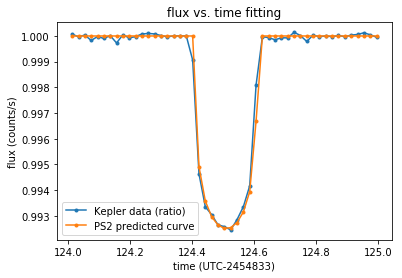

In [128]:
#plot the selected Kepler data and the calculated flux ratios
plt.plot(time_ext, ratio_fl, marker='.')
plt.plot(time_ext, simpson_fvals, marker='.')
plt.legend(['Kepler data (ratio)', 'PS2 predicted curve'])
plt.xlabel("time (UTC-2454833)")
plt.ylabel("flux (counts/s)")
plt.title("flux vs. time fitting")
plt.show()

By "eye," it looks like a good fit.

In [151]:
from scipy import integrate
import numpy

v = 46 #degrees of freedom v = N - M where N=49, the number of data points, and M=3

def q_func(t, v):
    f = math.exp(-t)*math.pow(t, (v/2)-1)
    return v
    
def calculate_pvalue(chi_squared):
    numerator = integrate.quad(q_func, (chi_squared/2), numpy.inf, (v,))
    denominator = integrate.quad(q_func, 0, numpy.inf, (v,))
    q = numerator[0]/denominator[0]
    return q


pval = calculate_pvalue(chi_squared)
print("pvalue: ",pval)
    

pvalue:  1.0


C:\Anaconda\lib\site-packages\scipy\integrate\quadpack.py:364: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


It is not a good fit based on the p-value (i.e. the probability of getting this chi-squared value by chance is 1.0).

# Problem 3

In [146]:
p = 0.0775
tau = 0.1
t_0 = 124.51
n = 1000
sigma = np.std(ratio_fl)

tau_vals = []
chi_sq_vals = []

for i in numpy.linspace(0.08, 0.13, 50):
    tau = i
    tau_vals.append(tau)
    simpson_fvals = []
    F_func()
    chi_squared = 0
    for i in range(0, len(flux_ext)):
        chi_squared += math.pow((ratio_fl[i] - simpson_fvals[i])/sigma, 2)
    chi_sq_vals.append(chi_squared)
    print(chi_squared)
    
min_chi_sq = min(chi_sq_vals) 
min_index = chi_sq_vals.index(min(chi_sq_vals))
print("\n")
print("Minimum chi-squared value: ",min_chi_sq)
print("Best fitting tau value: ",tau_vals[min_index])

5.667247126019547
5.438582855606379
5.278252098235688
4.993343761215171
4.591894857588747
4.126532366867674
3.6317436406953627
3.138950254387829
2.6695858962598944
2.2354705786581053
1.7994277595523056
1.3829125106931675
1.014596529282736
0.7101437200530366
0.4814792568690128
0.33383069389984193
0.26873542725571536
0.2649639445727979
0.31446259714804675
0.4127097117419533
0.5530295276365091
0.716428874013949
0.8772800499231734
1.0306033935145198
1.1489202337888014
1.2546590127587767
1.3718222085267469
1.5089786363720161
1.6729925105216032
1.8686337230788705
2.1015382143828427
2.3780529934539327
2.6999358965335127
3.0677329174404457
3.4786942668369196
3.9244776698104027
4.395618511484189
4.862244897765087
5.301592414023664
5.7457540285598245
6.20068062292731
6.667346893732556
7.142601542058951
7.623326229751329
8.102104022394284
8.559943250269056
8.964329827042326
9.360250891791503
9.761792164437779
10.177774451742383


Minimum chi-squared value:  0.2649639445727979
Best fitting tau val

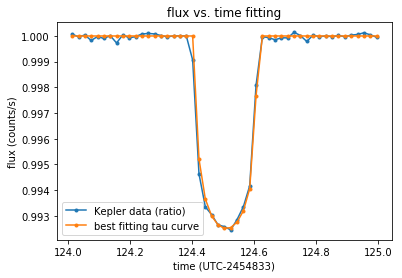

In [150]:
tau = tau_vals[min_index]
simpson_fvals = []
F_func()

#plot the selected Kepler data and the calculated flux ratios
plt.plot(time_ext, ratio_fl, marker='.')
plt.plot(time_ext, simpson_fvals, marker='.')
plt.legend(['Kepler data (ratio)', 'best fitting tau curve'])
plt.xlabel("time (UTC-2454833)")
plt.ylabel("flux (counts/s)")
plt.title("flux vs. time fitting")
plt.show()

In [152]:
pval = calculate_pvalue(min_chi_sq)
print("pvalue: ",pval)

pvalue:  1.0


C:\Anaconda\lib\site-packages\scipy\integrate\quadpack.py:364: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


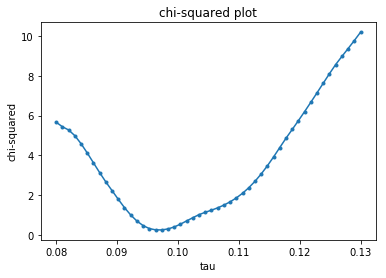

In [153]:
plt.plot(tau_vals, chi_sq_vals, marker='.')
plt.xlabel("tau")
plt.ylabel("chi-squared")
plt.title("chi-squared plot")
plt.show()

One-sigma uncertainty in tau parameter is approximately 0.0075.

# Problem 4

In [158]:
#from scipy.optimize import brute
import scipy.optimize

def min_func(tup):
    tau = tup[0]
    p = tup[1]
    t_0 = tup[2]
    simpson_fvals = []
    F_func()
    chi_squared = 0
    for i in range(0, len(flux_ext)):
        chi_squared += math.pow((ratio_fl[i] - simpson_fvals[i])/sigma, 2)
    return chi_squared

#print scipy.optimize.fmin_bfgs(testfn, (2,2)) 

#from scipy.optimize import minimize
opt = scipy.optimize.fmin_bfgs(min_func, (0.1, 0.0775, 124.51)) 
print(opt)
#print(opt)


#x, y, z, w = brute(min_func,ranges=((0.08, 0.13),(0.05, 0.12), (124, 125)),full_output = True)
#print(y)

IndexError: list index out of range

My apologies that I am unable to complete this problem within the time due to multiple health problems. 

I tried scipy.optimize.brute and scipy.optimize.minimize to minimize the chi-squared but could not get them to work.